
# Unified Silhouette Pipeline (HDR Coverage + Point-Fraction)

This notebook unifies both pipelines into one workflow with shared preprocessing, shared grid utilities, a common **ShapeProduct** interface, and a single metrics/plotting stack.  
You can toggle which variants to run and export figures/metrics side-by-side.

**Variants**
- `hdr` — *coverage mass on a float density field* (bootstrapped & smoothed) → mass-threshold isocontour.
- `point_fraction` — *densest subset of points (top p% by KDE)* → rasterized binary mask → contour.

> Semantics are preserved (mass vs densest-subset). Downstream metrics/plots are shared.


In [1]:
# silhouette_core.py
# Minimal, dependency-light core that runs HDR and/or PF given two CSVs + optional configs.

from __future__ import annotations
import os, json, math, itertools
from dataclasses import dataclass, asdict
from typing import Tuple, Dict, List, Optional, TypedDict, Literal

import numpy as np
import pandas as pd

from scipy.ndimage import gaussian_filter, binary_closing, binary_opening, binary_fill_holes
from scipy.spatial import cKDTree
from skimage.measure import find_contours
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
import numpy as np

# ---------------------------- Public Configs ----------------------------
@dataclass
class CfgCommon:
    grid_base: int = 160
    pad_frac: float = 0.05
    trim_q: float = 0.10
    icp_iters: int = 30
    sample_icp: int = 50000
    out_dir: str = "out_unified_core"

@dataclass
class CfgHDR:
    n_boot: int = 256
    sample_frac: float = 1.0
    sigma_px: float = 1.2
    density_floor_frac: float = 0.002
    mass_levels: Tuple[float, ...] = (1.00, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.60, 0.50)
    use_support_p100: bool = True
    support_min_hits: int = 1

@dataclass
class CfgPF:
    frac_levels: Tuple[float, ...] = (1.00, 0.95, 0.90, 0.80, 0.60, 0.50)
    bandwidth: Optional[float] = None
    disk_px: int = 2

# ---------------------------- Public Types ----------------------------
Plane = Literal["XY", "YZ", "XZ"]
Variant = Literal["hdr", "point_fraction", "support"]

class ShapeProduct(TypedDict):
    plane: Plane
    level: int              # 50,60,80,95,100
    variant: Variant
    mask: np.ndarray        # bool [ny, nx]
    contour: Optional[np.ndarray]  # [N,2] (row, col)

class RunResult(TypedDict):
    A: np.ndarray           # aligned & scaled 3D points (N,3)
    B: np.ndarray
    shapes: Dict[Variant, Dict[Plane, Dict[int, Tuple[ShapeProduct, ShapeProduct]]]]
    metrics: pd.DataFrame   # columns: plane, level, variant, IoU, meanNN, Hausdorff
    meta: dict
    background: Dict[Plane, np.ndarray]  # union-of-points mask per plane (bool [ny,nx])
    densities: Optional[Dict[str, Dict[Plane, np.ndarray]]]  # None if HDR not run; else {'A':{plane:D}, 'B':{...}}

# ---------------------------- IO ----------------------------
def load_points(csv: str) -> np.ndarray:
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv}")
    return P

# ---------------------------- Alignment ----------------------------
def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]]
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1)
    return float(np.sqrt((np.concatenate([dBA, dAB])**2).mean()))

def best_pca_prealign(B_pts, A_pts):
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            R = Va @ (P @ S) @ Vb.T
            rmse = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

def kabsch(P, Q):
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    rs = np.random.default_rng(seed)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        if 0.0 < trim_q < 0.5:
            thr = np.quantile(d, 1 - trim_q)
            keep = d <= thr
            P, Bx = P[keep], Bx[keep]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

# ---------------------------- Grid / Planes ----------------------------
PLANE_FROM_AXIS = {'z': 'XY', 'x': 'YZ', 'y': 'XZ'}
AXPAIR = {'z': (0,1), 'x': (1,2), 'y': (0,2)}

def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    mn, mx = P.min(0), P.max(0)
    ext = mx - mn
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    scale = base / float(ext.max() + 1e-8)
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    return edges, dims

def grid_centers_from_edges(ex, ey):
    nx = len(ex) - 1; ny = len(ey) - 1
    xs = np.linspace(ex[0], ex[-1], nx)
    ys = np.linspace(ey[0], ey[-1], ny)
    return xs, ys

def project_plane(P: np.ndarray, axis: str) -> np.ndarray:
    d = {'x': [1,2], 'y': [0,2], 'z': [0,1]}[axis]
    return P[:, d]

def rasterize_points(points2d: np.ndarray, xs, ys, disk_px=2) -> np.ndarray:
    ny, nx = len(ys), len(xs)
    img = np.zeros((ny, nx), dtype=bool)
    rr = np.arange(-disk_px, disk_px+1)
    XX, YY = np.meshgrid(rr, rr, indexing='xy')
    disk = (XX**2 + YY**2) <= (disk_px**2)
    dh, dw = disk.shape[0]//2, disk.shape[1]//2
    x_idx = np.clip(np.searchsorted(xs, points2d[:,0]) - 1, 0, nx-1)
    y_idx = np.clip(np.searchsorted(ys, points2d[:,1]) - 1, 0, ny-1)
    for y, x in zip(y_idx, x_idx):
        y0, y1 = max(0, y-dh), min(ny, y+dh+1)
        x0, x1 = max(0, x-dw), min(nx, x+dw+1)
        dy0 = 0 if y0==y-dh else (y-dh - y0)
        dx0 = 0 if x0==x-dw else (x-dw - x0)
        img[y0:y1, x0:x1] |= disk[dy0:dy0+(y1-y0), dx0:dx0+(x1-x0)]
    return img

# ---------------------------- Common metrics ----------------------------
def iou_bool(A: np.ndarray, B: np.ndarray) -> float:
    inter = np.logical_and(A,B).sum()
    union = np.logical_or(A,B).sum()
    return float(inter) / float(union + 1e-9)

def contour_distances(CA: Optional[np.ndarray], CB: Optional[np.ndarray]):
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    return float((da.mean()+db.mean())/2.0), float(max(da.max(), db.max()))

def contour_from_bool(M: np.ndarray) -> Optional[np.ndarray]:
    if M is None or M.sum() == 0: return None
    cs = find_contours(M.astype(float), level=0.5)
    if not cs: return None
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

# ---------------------------- HDR ----------------------------
def apply_density_floor(D: np.ndarray, frac: float) -> np.ndarray:
    if frac <= 0: return D
    eps = float(frac) * float(D.max() if np.isfinite(D.max()) else 0.0)
    if eps <= 0: return D
    Df = D.copy(); Df[Df < eps] = 0.0
    return Df

def mass_threshold(D: np.ndarray, mass: float) -> float:
    flat = D.ravel(); s = flat.sum()
    if s <= 0: return float('inf')
    if mass >= 0.999999:
        pos = flat[flat > 0]
        return float(pos.min()) if pos.size else float('inf')
    v = np.sort(flat)[::-1]; c = np.cumsum(v)
    return float(v[np.searchsorted(c, mass * c[-1], side='left')])

def contour_at_mass(D: np.ndarray, mass: float) -> Optional[np.ndarray]:
    tau = mass_threshold(D, mass)
    if not np.isfinite(tau): return None
    cs = find_contours(D, level=tau)
    if not cs: return None
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

def boot_density_and_support_2d(P: np.ndarray, edges3d, n_boot=256, sample_frac=1.0, sigma_px=1.2, support_min_hits=1):
    xed, yed, zed = edges3d
    plane_edges = {'z': (xed, yed), 'x': (yed, zed), 'y': (xed, zed)}
    accD = {a: None for a in ('x','y','z')}
    accC = {a: None for a in ('x','y','z')}
    n = len(P); k = max(1, int(round(sample_frac * n)))
    rs = np.random.default_rng(0)
    for _ in range(n_boot):
        idx = rs.integers(0, n, size=k); sub = P[idx]
        for a in ('x','y','z'):
            i, j = AXPAIR[a]; ex, ey = plane_edges[a]
            H, _, _ = np.histogram2d(sub[:, i], sub[:, j], bins=[ex, ey])
            D = gaussian_filter(H.astype(np.float32), sigma=sigma_px).T
            if accD[a] is None: accD[a] = D
            else: accD[a] += D
            S = (H > 0).T
            if accC[a] is None: accC[a] = S.astype(np.uint16)
            else: accC[a] += S.astype(np.uint16)
    outD = {a: (accD[a] / float(n_boot)) if accD[a] is not None else None for a in accD}
    outS = {a: (accC[a] >= support_min_hits) if accC[a] is not None else None for a in accC}
    return outD, outS

def make_hdr_shape(D: np.ndarray, plane: Plane, mass: float, density_floor_frac: float) -> ShapeProduct:
    Df = apply_density_floor(D, density_floor_frac)
    tau = mass_threshold(Df, mass)
    mask = (Df >= tau)
    contour = contour_at_mass(Df, mass)
    return dict(plane=plane, level=int(round(mass*100)), variant="hdr", mask=mask, contour=contour)

# ---------------------------- Point-Fraction ----------------------------
def kde_scores(points2d: np.ndarray, bandwidth: float) -> np.ndarray:
    if points2d.shape[0] < 2:
        return np.zeros(points2d.shape[0])
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(points2d)
    return kde.score_samples(points2d)

def auto_bandwidth(points2d: np.ndarray) -> float:
    N = points2d.shape[0]
    if N <= 1: return 1.0
    samp = points2d[np.random.choice(N, size=min(N, 500), replace=False)] if N > 500 else points2d
    md = np.median(pdist(samp)) if samp.shape[0] >= 2 else 1.0
    return max(1e-6, md * 0.5)

def point_fraction_mask(points2d: np.ndarray, xs, ys, frac: float, bandwidth: Optional[float], disk_px: int):
    N = points2d.shape[0]
    k = max(1, int(math.ceil(frac * N)))
    bw = auto_bandwidth(points2d) if bandwidth is None else bandwidth
    scores = kde_scores(points2d, bandwidth=bw)
    order = np.argsort(scores)[::-1]
    kept = points2d[order[:k]]
    mask = rasterize_points(kept, xs, ys, disk_px=disk_px)
    mask = binary_closing(mask, iterations=1)
    mask = binary_opening(mask, iterations=1)
    mask = biggest_component_mask(mask)
    return mask, kept, bw

def biggest_component_mask(mask: np.ndarray) -> np.ndarray:
    if mask.sum() == 0: return mask
    from scipy.ndimage import label as _label
    labeled_mask, num_features = _label(mask)
    if num_features == 0: return mask
    component_sizes = np.bincount(labeled_mask.ravel())
    if len(component_sizes) <= 1: return np.zeros_like(mask)
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    largest_component = (labeled_mask == largest_component_label)
    solid_mask = binary_fill_holes(largest_component)
    return solid_mask

def make_pf_shape(points2d: np.ndarray, xs, ys, plane: Plane, frac: float, bandwidth: Optional[float], disk_px: int) -> ShapeProduct:
    mask, kept, bw = point_fraction_mask(points2d, xs, ys, frac, bandwidth, disk_px)
    contour = contour_from_bool(mask)
    return dict(plane=plane, level=int(round(frac*100)), variant="point_fraction", mask=mask, contour=contour)

# ---------------------------- Orchestration ----------------------------
def _align_scale_and_grid(A_raw: np.ndarray, B_raw: np.ndarray, cfg: CfgCommon):
    A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)
    Rpre = best_pca_prealign(B0, A0)
    B1 = B0 @ Rpre.T
    Ricp, ticp = icp_rigid_robust(A0, B1, iters=cfg.icp_iters, sample=cfg.sample_icp, trim_q=cfg.trim_q)
    A_al, B_al = A0, (B1 @ Ricp.T + ticp)
    mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
    s = float((maxs - mins).max())
    A = A_al/s; B = B_al/s
    edges3d, _ = make_grid_from_bounds(np.vstack([A, B]), base=cfg.grid_base, pad_frac=cfg.pad_frac)
    return A, B, edges3d

def _per_plane_points(A: np.ndarray, B: np.ndarray, edges3d) -> Dict[Plane, Dict[str, np.ndarray]]:
    out = {}
    for a in ('x','y','z'):
        plane: Plane = PLANE_FROM_AXIS[a]  # type: ignore
        i, j = AXPAIR[a]
        ex, ey = edges3d[i], edges3d[j]
        xs, ys = grid_centers_from_edges(ex, ey)
        out[plane] = dict(xs=xs, ys=ys, A2=A[:,[i,j]], B2=B[:,[i,j]])
    return out

def _append_metrics(rows: List[dict], plane: Plane, level: int, variant: Variant,
                    MA: np.ndarray, MB: np.ndarray, CA: Optional[np.ndarray], CB: Optional[np.ndarray]):
    IoU = iou_bool(MA, MB)
    mnn, haus = contour_distances(CA, CB)
    rows.append(dict(plane=plane, level=level, variant=variant, IoU=IoU, meanNN=mnn, Hausdorff=haus))

def run_silhouettes(csv_A: str,
                    csv_B: str,
                    out_dir: Optional[str] = None,
                    run_hdr: bool = True,
                    run_pf: bool = True,
                    cfg_common: Optional[CfgCommon] = None,
                    cfg_hdr: Optional[CfgHDR] = None,
                    cfg_pf: Optional[CfgPF] = None) -> RunResult:
    """Minimal entrypoint: two files + optional configs. Writes artifacts if out_dir/cfg_common.out_dir set."""
    cfg_common = cfg_common or CfgCommon()
    if out_dir: cfg_common.out_dir = out_dir
    cfg_hdr = cfg_hdr or CfgHDR()
    cfg_pf = cfg_pf or CfgPF()
    os.makedirs(cfg_common.out_dir, exist_ok=True)

    # Load & preprocess
    A_raw, B_raw = load_points(csv_A), load_points(csv_B)
    A, B, edges3d = _align_scale_and_grid(A_raw, B_raw, cfg_common)
    per_plane = _per_plane_points(A, B, edges3d)

    # Background masks (for plotting if needed by caller)
    background = {
        plane: (rasterize_points(d["A2"], d["xs"], d["ys"], disk_px=2) |
                rasterize_points(d["B2"], d["xs"], d["ys"], disk_px=2))
        for plane, d in per_plane.items()
    }

    # HDR compute
    hdr_densA = hdr_densB = hdr_suppA = hdr_suppB = None
    if run_hdr:
        hdr_densA, hdr_suppA = boot_density_and_support_2d(A, edges3d,
            n_boot=cfg_hdr.n_boot, sample_frac=cfg_hdr.sample_frac,
            sigma_px=cfg_hdr.sigma_px, support_min_hits=cfg_hdr.support_min_hits)
        hdr_densB, hdr_suppB = boot_density_and_support_2d(B, edges3d,
            n_boot=cfg_hdr.n_boot, sample_frac=cfg_hdr.sample_frac,
            sigma_px=cfg_hdr.sigma_px, support_min_hits=cfg_hdr.support_min_hits)
        # Save raw densities for reuse
        for a in ('x','y','z'):
            plane = PLANE_FROM_AXIS[a]
            if hdr_densA[a] is not None and hdr_densB[a] is not None:
                np.save(os.path.join(cfg_common.out_dir, f"density_A_{plane}.npy"), hdr_densA[a])
                np.save(os.path.join(cfg_common.out_dir, f"density_B_{plane}.npy"), hdr_densB[a])

    # Build shapes + metrics
    shapes: Dict[Variant, Dict[Plane, Dict[int, Tuple[ShapeProduct, ShapeProduct]]]] = {}
    rows: List[dict] = []

    # HDR shapes
    if run_hdr and hdr_densA and hdr_densB:
        shapes.setdefault("hdr", {})
        for a in ('x','y','z'):
            plane: Plane = PLANE_FROM_AXIS[a]  # type: ignore
            D_A, D_B = hdr_densA[a], hdr_densB[a]
            if D_A is None or D_B is None: continue
            shapes["hdr"].setdefault(plane, {})
            for m in cfg_hdr.mass_levels:
                spA = make_hdr_shape(D_A, plane, m, cfg_hdr.density_floor_frac)
                spB = make_hdr_shape(D_B, plane, m, cfg_hdr.density_floor_frac)
                shapes["hdr"][plane][spA["level"]] = (spA, spB)
                _append_metrics(rows, plane, spA['level'], "hdr", spA['mask'], spB['mask'], spA['contour'], spB['contour'])
        if cfg_hdr.use_support_p100 and hdr_suppA and hdr_suppB:
            shapes.setdefault("support", {})
            for a in ('x','y','z'):
                plane: Plane = PLANE_FROM_AXIS[a]  # type: ignore
                SA, SB = hdr_suppA[a], hdr_suppB[a]
                if SA is None or SB is None: continue
                CA, CB = contour_from_bool(SA), contour_from_bool(SB)
                spA = dict(plane=plane, level=100, variant="support", mask=SA, contour=CA)
                spB = dict(plane=plane, level=100, variant="support", mask=SB, contour=CB)
                shapes["support"].setdefault(plane, {})[100] = (spA, spB)
                _append_metrics(rows, plane, 100, "support", SA, SB, CA, CB)

    # PF shapes
    if run_pf:
        shapes.setdefault("point_fraction", {})
        for plane, d in per_plane.items():
            xs, ys = d["xs"], d["ys"]; A2, B2 = d["A2"], d["B2"]
            for frac in cfg_pf.frac_levels:
                spA = make_pf_shape(A2, xs, ys, plane, frac, cfg_pf.bandwidth, cfg_pf.disk_px)
                spB = make_pf_shape(B2, xs, ys, plane, frac, cfg_pf.bandwidth, cfg_pf.disk_px)
                shapes["point_fraction"].setdefault(plane, {})[spA["level"]] = (spA, spB)
                _append_metrics(rows, plane, spA['level'], "point_fraction", spA['mask'], spB['mask'], spA['contour'], spB['contour'])

    # Metrics + meta
    metrics = pd.DataFrame(rows).sort_values(["plane","variant","level"], ascending=[True, True, False])
    metrics_path = os.path.join(cfg_common.out_dir, "metrics_unified.csv")
    metrics.to_csv(metrics_path, index=False)

    meta = dict(csv_A=csv_A, csv_B=csv_B,
                cfg_common=asdict(cfg_common), cfg_hdr=asdict(cfg_hdr), cfg_pf=asdict(cfg_pf),
                planes=list(per_plane.keys()))
    with open(os.path.join(cfg_common.out_dir, "meta_unified.json"), "w") as f:
        json.dump(meta, f, indent=2)

    # Pack densities (optional)
    densities = None
    if run_hdr and hdr_densA and hdr_densB:
        densities = {
            'A': {PLANE_FROM_AXIS[a]: hdr_densA[a] for a in ('x','y','z') if hdr_densA[a] is not None},
            'B': {PLANE_FROM_AXIS[a]: hdr_densB[a] for a in ('x','y','z') if hdr_densB[a] is not None},
        }

    return dict(
        A=A, B=B,
        shapes=shapes,
        metrics=metrics,
        meta=meta,
        background=background,     # NEW
        densities=densities        # NEW
    )

# ============================= Visualization helpers (optional) =============================

def _levels_from_result(kind: str, cfg_hdr: CfgHDR, cfg_pf: CfgPF, levels):
    # supports int, list[int], or "all"
    if isinstance(levels, str) and levels.lower() == "all":
        if kind == "hdr":
            return tuple(sorted({int(round(p*100)) for p in cfg_hdr.mass_levels}, reverse=True))
        if kind == "point_fraction":
            return tuple(sorted({int(round(p*100)) for p in cfg_pf.frac_levels}, reverse=True))
        if kind == "support":
            return (100,)
    if isinstance(levels, (list, tuple, set, np.ndarray)):
        return tuple(int(x) for x in levels)
    if isinstance(levels, (int, float)):
        return (int(levels),)
    raise ValueError("levels must be int, list[int], or 'all'")

def _plot_overlay(ax, shapeA: ShapeProduct, shapeB: ShapeProduct, bg: np.ndarray, title: str, labelA="A", labelB="B"):
    if bg is not None:
        ax.imshow(bg, cmap="gray", alpha=0.12)
    if shapeA.get("contour") is not None:
        C = shapeA["contour"]; ax.plot(C[:,1], C[:,0], '-', lw=2.4, color="#1f77b4", alpha=0.95,
                                       label=f"{labelA} {shapeA['variant']} {shapeA['level']}%")
    if shapeB.get("contour") is not None:
        C = shapeB["contour"]; ax.plot(C[:,1], C[:,0], '-', lw=2.4, color="#d62728", alpha=0.95,
                                       label=f"{labelB} {shapeB['variant']} {shapeB['level']}%")
    ax.set_title(title); ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")

def view(result: RunResult,
         kind: Literal["hdr","point_fraction","support"] = "hdr",
         plane: Plane = "XY",
         levels: "int|list[int]|str" = "all",
         *,
         labelA: str = "A",
         labelB: str = "B",
         show_heat: bool = False,
         cfg_hdr: Optional[CfgHDR] = None,
         cfg_pf: Optional[CfgPF] = None):
    """
    Quick viewer for shapes produced by run_silhouettes().
    - kind: 'hdr' | 'point_fraction' | 'support'
    - plane: 'XY' | 'YZ' | 'XZ'
    - levels: int | list[int] | 'all'
    - show_heat: if True and kind='hdr' and densities exist, show A's density heat under contours.
    """
    cfg_hdr = cfg_hdr or CfgHDR()
    cfg_pf  = cfg_pf  or CfgPF()
    lvls = _levels_from_result(kind, cfg_hdr, cfg_pf, levels)

    # choose shape table
    if kind == "support":
        lvls = (100,)

    if kind not in result["shapes"]:
        print(f"[view] No shapes for kind='{kind}'. Did you run with run_{kind}=True?")
        return

    shapes_by_plane = result["shapes"][kind]
    if plane not in shapes_by_plane:
        print(f"[view] No shapes for plane '{plane}' and kind '{kind}'.")
        return

    # figure
    fig, axes = plt.subplots(1, len(lvls), figsize=(5.4*len(lvls), 5.2))
    if not isinstance(axes, (list, np.ndarray)): axes = [axes]

    # density heat if available (A only, for context)
    D_A_plane = None
    if show_heat and kind == "hdr" and result.get("densities") and result["densities"].get("A"):
        D_A_plane = result["densities"]["A"].get(plane)

    for ax, lvl in zip(axes, lvls):
        pair = shapes_by_plane.get(plane, {}).get(lvl)
        if pair is None:
            ax.text(0.5, 0.5, f"No {kind} {lvl}%", ha="center", va="center"); ax.axis("off"); continue
        spA, spB = pair
        bg = result["background"].get(plane)
        if D_A_plane is not None:
            ax.imshow(D_A_plane, alpha=0.35)  # faint heat underlay
        _plot_overlay(ax, spA, spB, bg, f"{plane} — {kind} {lvl}%", labelA, labelB)
    plt.tight_layout(); plt.show()



   plane  level         variant       IoU     meanNN  Hausdorff
20    XY    100             hdr  0.750930   5.081812  23.236215
21    XY     99             hdr  0.634577   5.255348  23.170830
22    XY     98             hdr  0.591358   5.758198  22.632893
23    XY     97             hdr  0.561441   5.111475  17.845996
24    XY     96             hdr  0.534387   5.420998  19.098822
25    XY     95             hdr  0.512989   5.262549  20.272934
26    XY     90             hdr  0.446524   5.073710  25.015234
27    XY     80             hdr  0.359690   6.463194  33.117883
28    XY     60             hdr  0.231888   3.122064  15.582034
29    XY     50             hdr  0.195914   6.132452  23.355832
45    XY    100  point_fraction  0.722209   4.758943  21.931712
46    XY     95  point_fraction  0.694864   5.222500  21.931712
47    XY     90  point_fraction  0.672357   5.505131  17.804494
48    XY     80  point_fraction  0.664842   5.227704  16.552945
49    XY     60  point_fraction  0.68838

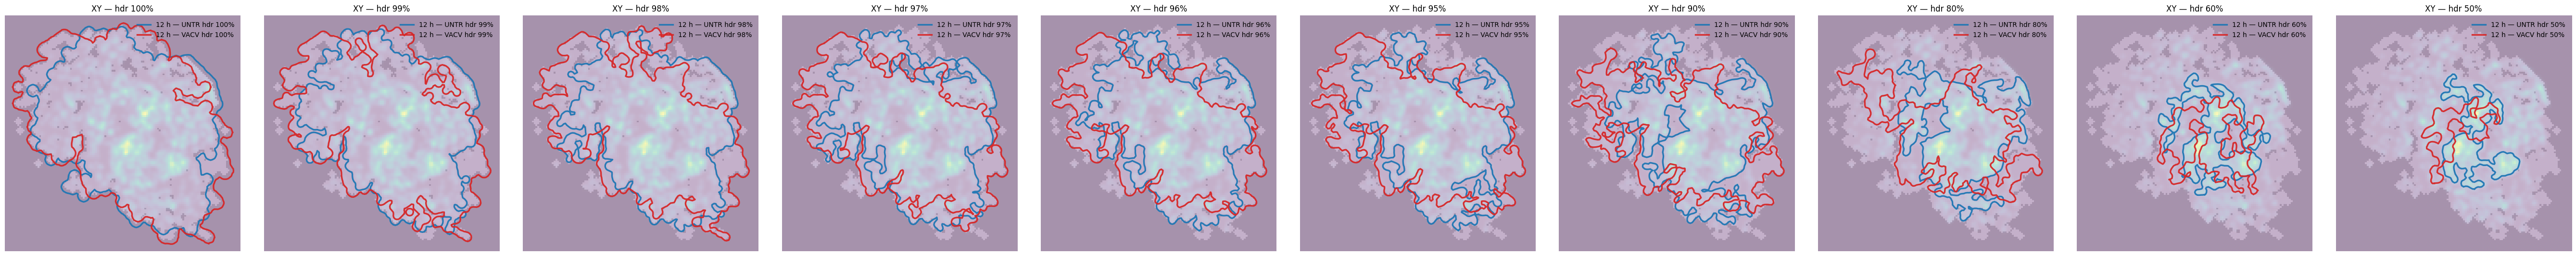

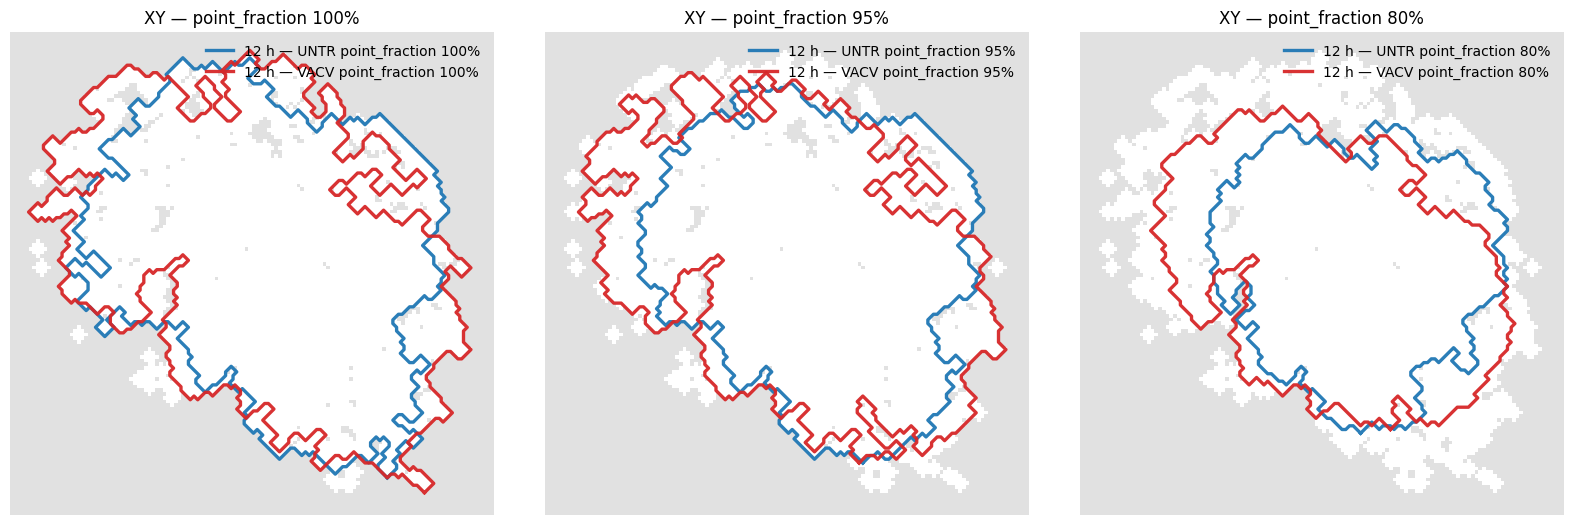

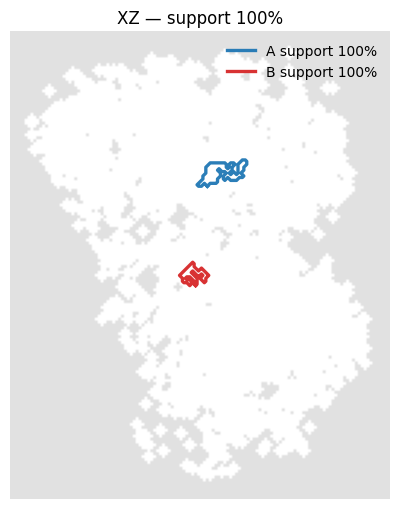

In [2]:
# from silhouette_core import run_silhouettes, CfgCommon, CfgHDR, CfgPF

res = run_silhouettes(
    csv_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv",
    csv_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv",
    out_dir="data/green_monkey/va_testing/out_silhouttes_unified",
    run_hdr=True, run_pf=True,
    cfg_common=CfgCommon(grid_base=160, pad_frac=0.05),
    cfg_hdr=CfgHDR(n_boot=256),
    cfg_pf=CfgPF(disk_px=2)
)

print(res['metrics'])

view(res, kind="hdr", plane="XY", levels="all", show_heat=True, labelA="12 h — UNTR", labelB="12 h — VACV")
view(res, kind="point_fraction", plane="XY", levels=[100,95,80], labelA="12 h — UNTR", labelB="12 h — VACV")
view(res, kind="support", plane="XZ")  # single level = 100
